# Kmeans Clustering of Covid-19 regions
In this, part 2 section 2 of our Covid-19 study, we look at an abundance of possible features and try to determine which are most indicative of how a county in the United States will be affected by Covid-19

**Matt Paterson, hello@hireMattPaterson.com**<br>
**Machine Learning Engineer**<br>
**Cloud Brigade, Santa Cruz, CA**

In [111]:
# Import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model      import LogisticRegression, LinearRegression
from sklearn.model_selection   import train_test_split, cross_val_score
from sklearn.cluster           import KMeans
from sklearn.decomposition     import PCA
from sklearn.preprocessing     import StandardScaler, OneHotEncoder, PolynomialFeatures

As we step through this notebook we will import a number of data sets. To start with, we'll see how the kmeans clustering algorithm creates a heatmap of the United States using the confirmed cases and deaths numbers.

In [2]:
path_to_home = '../'
datapath = path_to_home + 'data/'

In [3]:
# Pull in the dataframe that we created in the LinearRegression notebook
filename = 'cov_BEA_starting.csv'

covid_df = pd.read_csv(datapath + filename)
covid_df.head()

,county-state,date,state,confirmed_cases,deaths,latitude,longitude,average_temperature_celsius,rainfall_mm,fips,...,Year,Employer_contrib_govt_and_social_insurance,Income_maintenance_benefits,Percapita_unemployment_insurance_compensation,Wages_and_salaries_supplement,Wages_and_salaries_avg,Net_earnings_by_place_of_residence,Percapita_personal_income,Population,jobs
0,"Lavaca County, Texas",2020-09-16,Texas,705.0,33.0,29.38,-96.94,26.992063,1.161143,48285.0,...,1/1/2018,17707.0,11968.0,52.0,63289.0,38553.0,527264.0,50919.0,20110.0,6624.0
1,"Lee County, Texas",2020-09-16,Texas,211.0,14.0,30.31,-96.96,26.625000,0.095250,48287.0,...,1/1/2018,25423.0,10241.0,64.0,82595.0,50270.0,474553.0,46713.0,17144.0,7401.0
2,"Leon County, Texas",2020-09-16,Texas,225.0,5.0,31.30,-96.00,25.805556,0.095250,48289.0,...,1/1/2018,19083.0,12464.0,67.0,61160.0,51582.0,346759.0,40388.0,17270.0,5353.0
3,"Liberty County, Texas",2020-09-16,Texas,2201.0,47.0,30.15,-94.81,28.626984,0.000000,48291.0,...,1/1/2018,60845.0,76126.0,85.0,216436.0,46503.0,2104398.0,37237.0,86323.0,19373.0
4,"Limestone County, Texas",2020-09-16,Texas,536.0,10.0,31.54,-96.58,25.370370,0.000000,48293.0,...,1/1/2018,22449.0,20839.0,63.0,104346.0,42817.0,418205.0,35771.0,23519.0,8432.0


Re-set the index to be the county-state column

In [4]:
covid_df.set_index('county-state', inplace=True)

We won't need some of these columns. Create a new dataframe that is a copy of the features that we need from this one

In [5]:
covid_df.columns

Index(['date', 'state', 'confirmed_cases', 'deaths', 'latitude', 'longitude',
       'average_temperature_celsius', 'rainfall_mm', 'fips', 'AK', 'AL', 'AR',
       'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI',
       'VT', 'WA', 'WI', 'WV', 'WY', 'GeoFIPS', 'Year',
       'Employer_contrib_govt_and_social_insurance',
       'Income_maintenance_benefits',
       'Percapita_unemployment_insurance_compensation',
       'Wages_and_salaries_supplement', 'Wages_and_salaries_avg',
       'Net_earnings_by_place_of_residence', 'Percapita_personal_income',
       'Population', 'jobs'],
      dtype='object')

In [6]:
df = covid_df[['state', 'fips', 'Population', 'confirmed_cases', 'deaths', 'latitude', 'longitude', 'average_temperature_celsius', 'rainfall_mm', 
              'jobs', 'Employer_contrib_govt_and_social_insurance', 'Income_maintenance_benefits', 'Percapita_unemployment_insurance_compensation',
             'Wages_and_salaries_supplement', 'Wages_and_salaries_avg', 'Net_earnings_by_place_of_residence', 
              'Percapita_personal_income']]

In [7]:
df.head()

,state,fips,Population,confirmed_cases,deaths,latitude,longitude,average_temperature_celsius,rainfall_mm,jobs,Employer_contrib_govt_and_social_insurance,Income_maintenance_benefits,Percapita_unemployment_insurance_compensation,Wages_and_salaries_supplement,Wages_and_salaries_avg,Net_earnings_by_place_of_residence,Percapita_personal_income
county-state,,,,,,,,,,,,,,,,,
"Lavaca County, Texas",Texas,48285.0,20110.0,705.0,33.0,29.38,-96.94,26.992063,1.161143,6624.0,17707.0,11968.0,52.0,63289.0,38553.0,527264.0,50919.0
"Lee County, Texas",Texas,48287.0,17144.0,211.0,14.0,30.31,-96.96,26.625000,0.095250,7401.0,25423.0,10241.0,64.0,82595.0,50270.0,474553.0,46713.0
"Leon County, Texas",Texas,48289.0,17270.0,225.0,5.0,31.30,-96.00,25.805556,0.095250,5353.0,19083.0,12464.0,67.0,61160.0,51582.0,346759.0,40388.0
"Liberty County, Texas",Texas,48291.0,86323.0,2201.0,47.0,30.15,-94.81,28.626984,0.000000,19373.0,60845.0,76126.0,85.0,216436.0,46503.0,2104398.0,37237.0
"Limestone County, Texas",Texas,48293.0,23519.0,536.0,10.0,31.54,-96.58,25.370370,0.000000,8432.0,22449.0,20839.0,63.0,104346.0,42817.0,418205.0,35771.0


In [8]:
df.shape

(3076, 17)

## Latitude and Longitude Covid Map

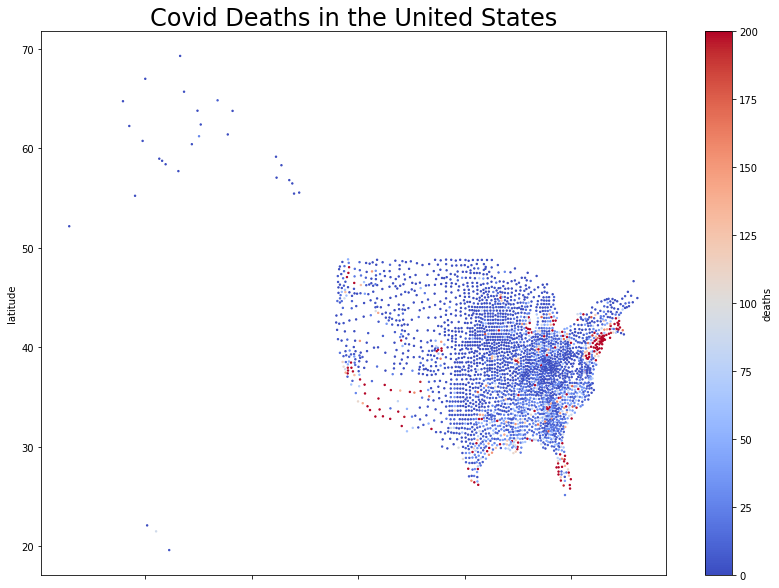

In [9]:
df.plot(kind="scatter", x="longitude", y="latitude", c="deaths",
         cmap="coolwarm", figsize=(14, 10), s=2, vmin=200, vmax=0);
plt.title("Covid Deaths in the United States", fontsize=24);

Make our map more readable using only the lower forty-eight states

In [10]:
df_lower = df[(df['state'] != 'Alaska') & (df['state'] != 'Hawaii')]

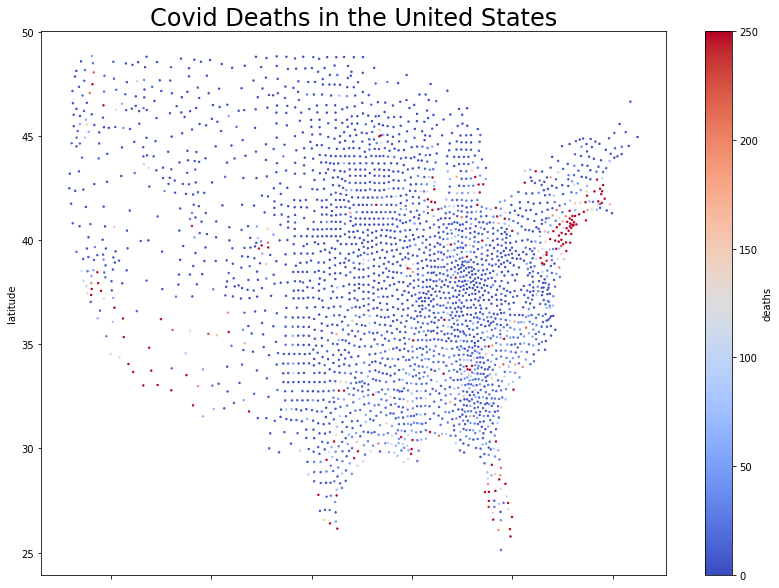

In [11]:
df_lower.plot(kind="scatter", x="longitude", y="latitude", c="deaths",
         cmap="coolwarm", figsize=(14, 10), s=2, vmin=250, vmax=0);
plt.title("Covid Deaths in the United States", fontsize=24);

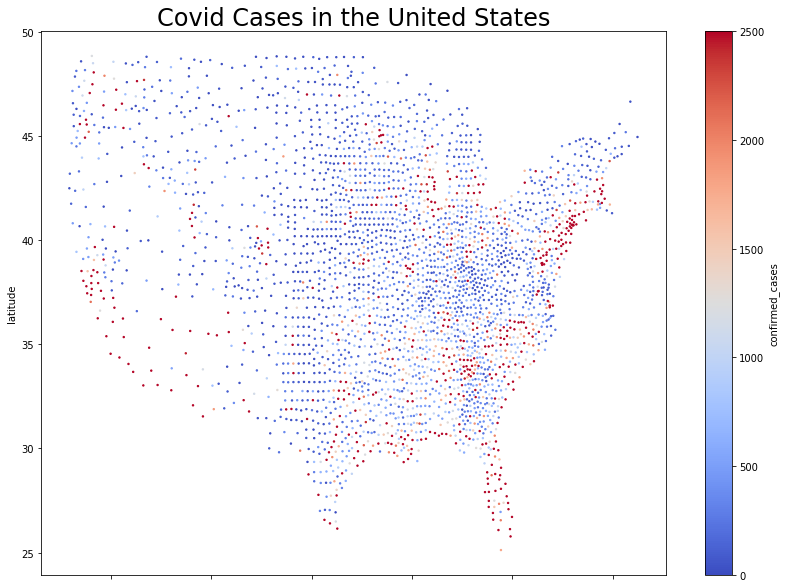

In [12]:
df_lower.plot(kind="scatter", x="longitude", y="latitude", c="confirmed_cases",
         cmap="coolwarm", figsize=(14, 10), s=2, vmin=2500, vmax=0);
plt.title("Covid Cases in the United States", fontsize=24);

The above map is only using geo-spatial data. We want to now start introducing features to model on, and see what areas in this map share traits and how the Kmeans clustering algorithm can lend us insight into the pandemic

In [13]:
# Create a list that has the racial/gender/age data for each state
states = os.listdir(datapath + 'age_sex_2019-07-01/')

In [14]:
# As an example, we can step through the states 
# list and create individual dataframes

filename = 'age_sex_2019-07-01/' + states[0]

al_df = pd.read_csv(datapath + filename)
al_df.head(2)

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,2,13,Alaska,Aleutians East Borough,1,0,3141,2093,1048,...,277,64,9,1,12,5,18,6,0,0
1,50,2,13,Alaska,Aleutians East Borough,1,1,123,68,55,...,1,3,0,0,1,0,0,1,0,0


In [15]:
# But we also have this complete data set to work with

filename = 'us_racial.csv'

us_df = pd.read_csv(datapath + filename)
us_df.shape

(716376, 80)

These 716,376 rows with 80 columns each tell us the population by age, race, and gender in all of our counties. We just need to get this data into the same format as our covid dataset and then we can pump it in to a PCA algorithm and eventually a Kmeans clustering algorithm to see where we have similarities.

This demographic data is all found in the US Census Bureau's Website at:
https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html

and an associated data dictionary is found at 
https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf

In [16]:
us_df.columns

Index(['SUMLEV', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'YEAR', 'AGEGRP',
       'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE',
       'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE',
       'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE',
       'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE',
       'AAC_FEMALE', 'NAC_MALE', 'NAC_FEMALE', 'NH_MALE', 'NH_FEMALE',
       'NHWA_MALE', 'NHWA_FEMALE', 'NHBA_MALE', 'NHBA_FEMALE', 'NHIA_MALE',
       'NHIA_FEMALE', 'NHAA_MALE', 'NHAA_FEMALE', 'NHNA_MALE', 'NHNA_FEMALE',
       'NHTOM_MALE', 'NHTOM_FEMALE', 'NHWAC_MALE', 'NHWAC_FEMALE',
       'NHBAC_MALE', 'NHBAC_FEMALE', 'NHIAC_MALE', 'NHIAC_FEMALE',
       'NHAAC_MALE', 'NHAAC_FEMALE', 'NHNAC_MALE', 'NHNAC_FEMALE', 'H_MALE',
       'H_FEMALE', 'HWA_MALE', 'HWA_FEMALE', 'HBA_MALE', 'HBA_FEMALE',
       'HIA_MALE', 'HIA_FEMALE', 'HAA_MALE', 'HAA_FEMALE', 'HNA_MALE',
       'HNA_FEMALE', 'HTOM_MALE', 'HTOM_FEMALE

In [17]:
us_df.head(2)

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,1,1,Alabama,Autauga County,1,0,54571,26569,28002,...,607,538,57,48,26,32,9,11,19,10
1,50,1,1,Alabama,Autauga County,1,1,3579,1866,1713,...,77,56,9,5,4,1,0,0,2,1


In [18]:
us_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716376 entries, 0 to 716375
Data columns (total 80 columns):
SUMLEV          716376 non-null int64
STATE           716376 non-null int64
COUNTY          716376 non-null int64
STNAME          716376 non-null object
CTYNAME         716376 non-null object
YEAR            716376 non-null int64
AGEGRP          716376 non-null int64
TOT_POP         716376 non-null int64
TOT_MALE        716376 non-null int64
TOT_FEMALE      716376 non-null int64
WA_MALE         716376 non-null int64
WA_FEMALE       716376 non-null int64
BA_MALE         716376 non-null int64
BA_FEMALE       716376 non-null int64
IA_MALE         716376 non-null int64
IA_FEMALE       716376 non-null int64
AA_MALE         716376 non-null int64
AA_FEMALE       716376 non-null int64
NA_MALE         716376 non-null int64
NA_FEMALE       716376 non-null int64
TOM_MALE        716376 non-null int64
TOM_FEMALE      716376 non-null int64
WAC_MALE        716376 non-null int64
WAC_FEMALE   

All of our columns are nearly ready for machine learning. The good news is that there are no null values and that the only non-numeric columns are the county and state, which we'll put together and use to join this table with our covid_df.

In [19]:
us_df.groupby(by=['STNAME', 'CTYNAME', 'AGEGRP']).sum().drop(columns=['SUMLEV', 'STATE', 'COUNTY', 'YEAR'])

TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  \
STNAME  CTYNAME        AGEGRP                                           
Alabama Autauga County 0        660641    321807      338834   253495   
                       1         40325     21013       19312    15684   
                       2         44845     22794       22051    17079   
                       3         49507     24955       24552    18750   
                       4         47639     24591       23048    18030   
...                                ...       ...         ...      ...   
Wyoming Weston County  14         4675      2441        2234     2360   
                       15         3547      1706        1841     1672   
                       16         2591      1150        1441     1134   
                       17         2042       961        1081      940   
                       18         2283       817        1466      807   

                               WA_FEMALE  BA_MALE  BA_FEMALE  IA_MALE  \
STNAME  CTYNAME        AGEGRP                                           
Alabama Autauga County 0          262620    58119      64786     1435   
                       1           14321     4008       3861       57   
                       2           16612     4527       4291       96   
                       3           18668     5167       4742      124   
                       4           17352     5541       4816      113   
...                                  ...      ...        ...      ...   
Wyoming Weston County  14           2177        0          1       10   
                       15           1809        0          0        3   
                       16           1413        0          0        0   
                       17           1064        0          0       15   
                       18           1460        0          0        9   

                               IA_FEMALE  AA_MALE  ...  HWAC_MALE  \
STNAME  CTYNAME        AGEGRP                      ...              
Alabama Autauga County 0            1732     2892  ...       7899   
                       1              55      201  ...        944   
                       2              83      198  ...        849   
                       3             100      235  ...        759   
                       4              84      319  ...        601   
...                                  ...      ...  ...        ...   
Wyoming Weston County  14             14       34  ...         28   
                       15             23        6  ...         13   
                       16             19        0  ...         13   
                       17              7        0  ...          9   
                       18              1        0  ...          3   

                               HWAC_FEMALE  HBAC_MALE  HBAC_FEMALE  HIAC_MALE  \
STNAME  CTYNAME        AGEGRP                                                   
Alabama Autauga County 0              7167        935          801        382   
                       1               660         94           73         52   
                       2               764         76           58         48   
                       3               764        116           88         47   
                       4               577         99           74         35   
...                                    ...        ...          ...        ...   
Wyoming Weston County  14               24          0            0          0   
                       15               11          0            0          0   
                       16               13          0            0          0   
                       17                6          0            0         12   
                       18               21          0            0          0   

                               HIAC_FEMALE  HAAC_MALE  HAAC_FEMALE  HNAC_MALE  \
STNAME  CTYNAME        AGEGRP                                                   
Alabama Autauga C

In [20]:
us_unorganized_df = us_df.groupby(by=['STNAME', 'CTYNAME', 'AGEGRP']).sum().drop(columns=['SUMLEV', 'STATE', 'COUNTY', 'YEAR'])
us_unorganized_df.head(3)

TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  \
STNAME  CTYNAME        AGEGRP                                           
Alabama Autauga County 0        660641    321807      338834   253495   
                       1         40325     21013       19312    15684   
                       2         44845     22794       22051    17079   

                               WA_FEMALE  BA_MALE  BA_FEMALE  IA_MALE  \
STNAME  CTYNAME        AGEGRP                                           
Alabama Autauga County 0          262620    58119      64786     1435   
                       1           14321     4008       3861       57   
                       2           16612     4527       4291       96   

                               IA_FEMALE  AA_MALE  ...  HWAC_MALE  \
STNAME  CTYNAME        AGEGRP                      ...              
Alabama Autauga County 0            1732     2892  ...       7899   
                       1              55      201  ...        944   
                       2              83      198  ...        849   

                               HWAC_FEMALE  HBAC_MALE  HBAC_FEMALE  HIAC_MALE  \
STNAME  CTYNAME        AGEGRP                                                   
Alabama Autauga County 0              7167        935          801        382   
                       1               660         94           73         52   
                       2               764         76           58         48   

                               HIAC_FEMALE  HAAC_MALE  HAAC_FEMALE  HNAC_MALE  \
STNAME  CTYNAME        AGEGRP                                                   
Alabama Autauga County 0               403        155          178        204   
                       1                44         13           34         14   
                       2                45         31           17         16   

                               HNAC_FEMALE  
STNAME  CTYNAME        AGEGRP               
Alabama Autauga County 0               130  
                       1                16  
                       2                10  

[3 rows x 73 columns]

In [21]:
us_unorganized_df.loc['Alabama','Autauga County']

,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
AGEGRP,,,,,,,,,,,,,,,,,,,,,
0,660641,321807,338834,253495,262620,58119,64786,1435,1732,2892,...,7899,7167,935,801,382,403,155,178,204,130
1,40325,21013,19312,15684,14321,4008,3861,57,55,201,...,944,660,94,73,52,44,13,34,14,16
2,44845,22794,22051,17079,16612,4527,4291,96,83,198,...,849,764,76,58,48,45,31,17,16,10
3,49507,24955,24552,18750,18668,5167,4742,124,100,235,...,759,764,116,88,47,61,20,26,29,16
4,47639,24591,23048,18030,17352,5541,4816,113,84,319,...,601,577,99,74,35,40,31,21,26,16
5,39582,20154,19428,14927,14542,4424,4268,86,116,236,...,649,462,51,50,18,25,9,5,22,6
6,40657,20060,20597,15333,15552,4127,4456,57,70,151,...,762,546,39,52,20,16,17,5,37,21
7,40857,19769,21088,15434,15731,3833,4616,51,102,206,...,722,650,64,40,13,22,6,7,21,14
8,45256,21760,23496,17118,17473,3941,5085,93,127,281,...,650,578,76,38,26,42,2,13,17,12


Now that we have the us_df grouped by county and state, we'll want to transform it into yet another dataframe. This one, this new sifted dataframe, should have each county-state in its own row, with each age group having its own set of rows that correspond to the us_unorganized_df. This should then have somewhere around 1300 columns

## Create a dataframe with the ages broken up

## Create a dataframe of the demographis without the age group breakdown

In [22]:
us_demos_df = us_df[(us_df['AGEGRP']==0) & (us_df['YEAR']==12)]
us_demos_df.shape

(3142, 80)

In [23]:
us_demos_df.head(2)

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
209,50,1,1,Alabama,Autauga County,12,0,55869,27092,28777,...,778,687,89,93,40,27,15,19,16,11
437,50,1,3,Alabama,Baldwin County,12,0,223234,108247,114987,...,5144,4646,268,281,264,197,69,65,55,35


Create a function in order to generate a 5 digit fips code to use to marry the new dataframe with the original covid_df

In [24]:
def fips_builder(state, county):
    '''
    returns an int, a 4 or 5 digit code denoting the county's 4 or 5 digit fips code
    state is an int, the state fips code
    county is an int, the county fips code
    '''
    
    state_str = str(state)
    county_str = str(county)
    
    while len(county_str) < 3:
        county_str = '0'+county_str
    
    fips_str = state_str + county_str
    
    return int(fips_str)
    

In [25]:
#us_demos_df['fips'] = fips_builder(us_demos_df['STATE'], us_demos_df['COUNTY'])

In [26]:
us_demos_df['county_state'] = us_demos_df['CTYNAME'] + ", " + us_demos_df['STNAME']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
us_demos_df.columns

Index(['SUMLEV', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'YEAR', 'AGEGRP',
       'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE',
       'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE',
       'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE',
       'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE',
       'AAC_FEMALE', 'NAC_MALE', 'NAC_FEMALE', 'NH_MALE', 'NH_FEMALE',
       'NHWA_MALE', 'NHWA_FEMALE', 'NHBA_MALE', 'NHBA_FEMALE', 'NHIA_MALE',
       'NHIA_FEMALE', 'NHAA_MALE', 'NHAA_FEMALE', 'NHNA_MALE', 'NHNA_FEMALE',
       'NHTOM_MALE', 'NHTOM_FEMALE', 'NHWAC_MALE', 'NHWAC_FEMALE',
       'NHBAC_MALE', 'NHBAC_FEMALE', 'NHIAC_MALE', 'NHIAC_FEMALE',
       'NHAAC_MALE', 'NHAAC_FEMALE', 'NHNAC_MALE', 'NHNAC_FEMALE', 'H_MALE',
       'H_FEMALE', 'HWA_MALE', 'HWA_FEMALE', 'HBA_MALE', 'HBA_FEMALE',
       'HIA_MALE', 'HIA_FEMALE', 'HAA_MALE', 'HAA_FEMALE', 'HNA_MALE',
       'HNA_FEMALE', 'HTOM_MALE', 'HTOM_FEMALE

In [28]:
us_demos_df.set_index('county_state', inplace=True)

In [29]:
df = pd.merge(covid_df, us_demos_df,'left', left_on=covid_df.index, right_on='county_state')

In [30]:
df.head(2)

,county_state,date,state,confirmed_cases,deaths,latitude,longitude,average_temperature_celsius,rainfall_mm,fips,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,"Lavaca County, Texas",2020-09-16,Texas,705.0,33.0,29.38,-96.94,26.992063,1.161143,48285.0,...,1871.0,1828.0,98.0,105.0,63.0,64.0,7.0,8.0,3.0,2.0
1,"Lee County, Texas",2020-09-16,Texas,211.0,14.0,30.31,-96.96,26.625000,0.095250,48287.0,...,2029.0,1931.0,55.0,58.0,92.0,63.0,12.0,13.0,11.0,9.0


In [31]:
df.shape

(3076, 157)

## We now have a dataframe with just shy of 3100 rows and 157 columns. We can now create a clustering algorithm to look at the severity of covid-19 by racial and gender makeup of each county as well as economic indicators.

In [32]:
df = df[df['state'] != 'Alaska']

In [33]:
df = df[df['state'] != 'Hawaii']

In [34]:
nulls = list(df.isna().sum())
df.isna().sum()
df[['county_state', 'HIAC_FEMALE']][df['HIAC_FEMALE'].isna()]
# Printing this list, we see that we have 36 null rows in the gender/racial makup columns

,county_state,HIAC_FEMALE
411,"Alexandria, Virginia",NaN
412,"Chesapeake, Virginia",NaN
413,"Hampton, Virginia",NaN
414,"Newport News, Virginia",NaN
415,"Norfolk, Virginia",NaN
416,"Portsmouth, Virginia",NaN
417,"Richmond, Virginia",NaN
418,"Roanoke, Virginia",NaN
419,"Suffolk, Virginia",NaN
420,"Virginia Beach, Virginia",NaN


It looks like Baltimore and St. Louis are in the list of 36 counties where we are missing demographics data. We can scrutinize this more, maybe seek another dataset to pull their information from, or we can plow ahead and drop these rows from the data set. 

For today, let's do that latter. If we revisit the project then we should do the former.

In [35]:
big_data = df[df['HIAC_FEMALE'].notna()]
big_data = big_data.drop(columns=['Year', 'SUMLEV', 'STATE',
                         'COUNTY', 'STNAME', 'CTYNAME','YEAR']).copy()
big_data.shape

(3035, 150)

## Part A: get a baseline look

In [36]:
# Instantiate a KMeans model with 100 clusters
km = KMeans(n_clusters=100)

Do a train_test_split of the data set, and then run it through the standard scaler before setting it in to the PCA algorithm

In [37]:
big_data.set_index('county_state', inplace=True)
all_feats = []
for col in big_data.columns:
    print("'"+col+"',")
all_feats = list(big_data.columns)

'date',
'state',
'confirmed_cases',
'deaths',
'latitude',
'longitude',
'average_temperature_celsius',
'rainfall_mm',
'fips',
'AK',
'AL',
'AR',
'AS',
'AZ',
'CA',
'CO',
'CT',
'DC',
'DE',
'FL',
'GA',
'GU',
'HI',
'IA',
'ID',
'IL',
'IN',
'KS',
'KY',
'LA',
'MA',
'MD',
'ME',
'MI',
'MN',
'MO',
'MP',
'MS',
'MT',
'NC',
'ND',
'NE',
'NH',
'NJ',
'NM',
'NV',
'NY',
'OH',
'OK',
'OR',
'PA',
'PR',
'RI',
'SC',
'SD',
'TN',
'TX',
'UT',
'VA',
'VI',
'VT',
'WA',
'WI',
'WV',
'WY',
'GeoFIPS',
'Employer_contrib_govt_and_social_insurance',
'Income_maintenance_benefits',
'Percapita_unemployment_insurance_compensation',
'Wages_and_salaries_supplement',
'Wages_and_salaries_avg',
'Net_earnings_by_place_of_residence',
'Percapita_personal_income',
'Population',
'jobs',
'AGEGRP',
'TOT_POP',
'TOT_MALE',
'TOT_FEMALE',
'WA_MALE',
'WA_FEMALE',
'BA_MALE',
'BA_FEMALE',
'IA_MALE',
'IA_FEMALE',
'AA_MALE',
'AA_FEMALE',
'NA_MALE',
'NA_FEMALE',
'TOM_MALE',
'TOM_FEMALE',
'WAC_MALE',
'WAC_FEMALE',
'BAC_MALE',
'BAC_FEMALE',
'IAC_MALE

In [38]:
geog = ['latitude', 'longitude']
no_need_cols = ['date', 'state','STATE', 'latitude', 'longitude', 'fips', 'GeoFIPS']
for feat in all_feats:
    if feat in no_need_cols:
        all_feats.remove(feat)
all_feats.remove('state')

In [39]:
# Use Standard Scaler on the data so that it fits in Kmeans

X = big_data[all_feats]

# Instantiate our StandardScaler
ss = StandardScaler()

# Standardize
X_sc = ss.fit_transform(X)

In [40]:
# fit the kmeans model to the training data
km.fit(X_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [41]:
# # Use KMeans to cluster geographically and then graph for a look
# kmg = KMeans(n_clusters=100)
# kmg.fit(geog_clus)
# plt.figure(figsize=(10, 10))
# plt.scatter(dri_model.longitude, dri_model.latitude, c=kmg.labels_, s=1, cmap="tab20");

Map out the clusters. We dropped Alaska and Hawaii so that we can see our map more clearly.

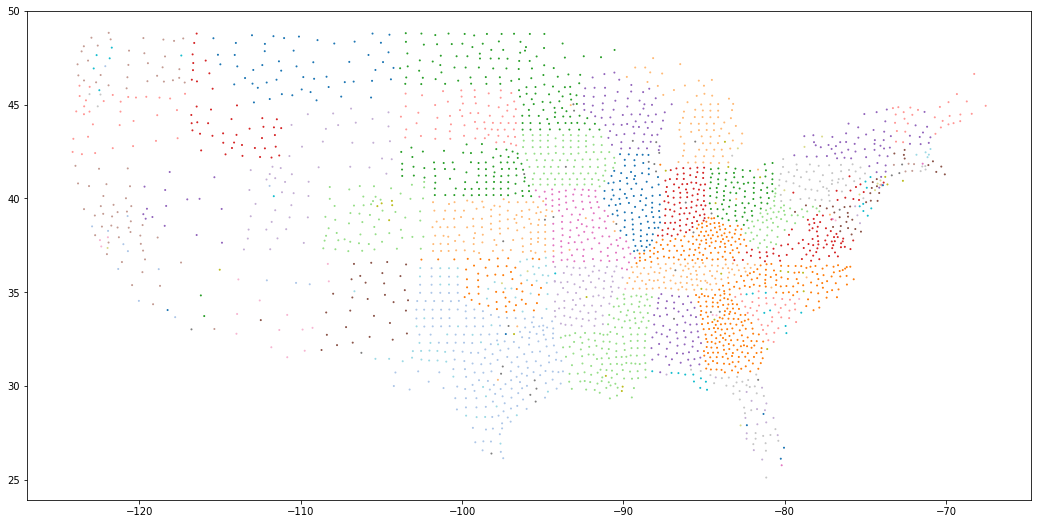

In [42]:
plt.figure(figsize=(18, 9))
plt.scatter(big_data.longitude, big_data.latitude, c=km.labels_, s=1, cmap='tab20');

Put this into an algorithm

In [43]:
def cluster_map(data, features, n_clusters, cmap='tab20'):
    '''
    Returns a kmeans clustering model of the DataFrame data and prints a map
            provided the dataset contains latitude and longitude data
    data    a Pandas DataFrame, must contain a column titled 'longitude' and
            also must contain a column titled 'latitude'
    features a list of numeric columns, all categorical data must be one-hot-encoded,
             this list will be used to build the KMeans model from the data DataFrame
             thus the list should match the DataFrame columns and is case-sensitive
    n_clusters an int, the number of clusters the KMeans model should return
    cmap    the color-scheme for the map
    '''
    
    # Un-comment these imports if porting this function to a library
    # import pandas as pd
    # from sklearn.cluster           import KMeans
    # from sklearn.decomposition     import PCA
    # from sklearn.preprocessing     import StandardScaler
    
    # create the scaled features matrix
    X = data[features]
    ss = StandardScaler()
    X_sc = ss.fit_transform(X)
    
    # create the cluster model
    model = KMeans(n_clusters = n_clusters)
    model.fit(X_sc)
    
    # map the resulting clusters
    plt.figure(figsize=(18, 9))
    plt.title(f'Map of {n_clusters} Clusters, Clusters like similar colored clusters', 
             fontsize = 36)
    plt.scatter(data.longitude, data.latitude, c=model.labels_, s=1, cmap=cmap);
    
    return model

## Iterate over several possible combinations of features and number of clusters

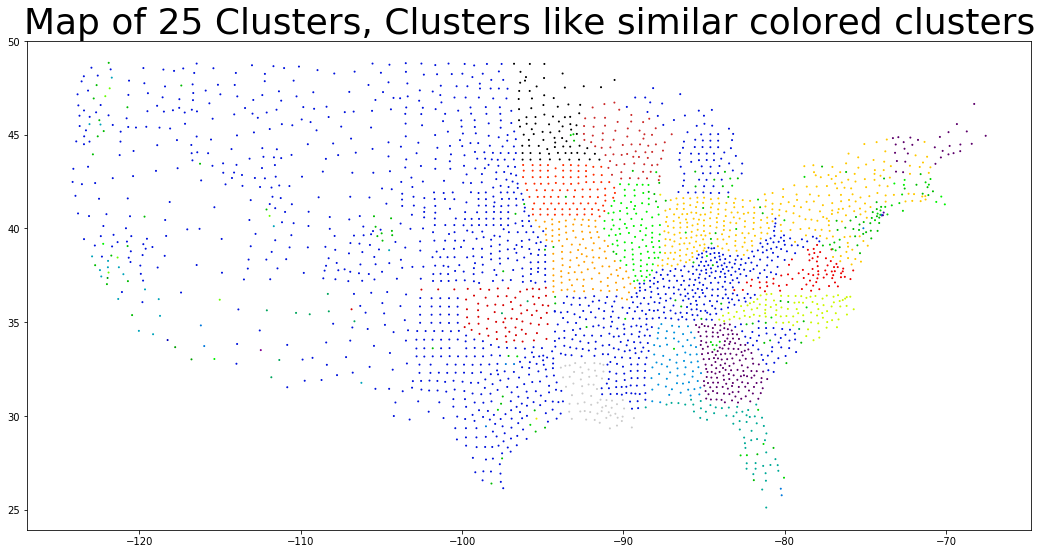

In [44]:
cluster_map(big_data, all_feats, 25, cmap='nipy_spectral');

## Set the color map here, colors = cmap

In [45]:
colors = 'gist_ncar'

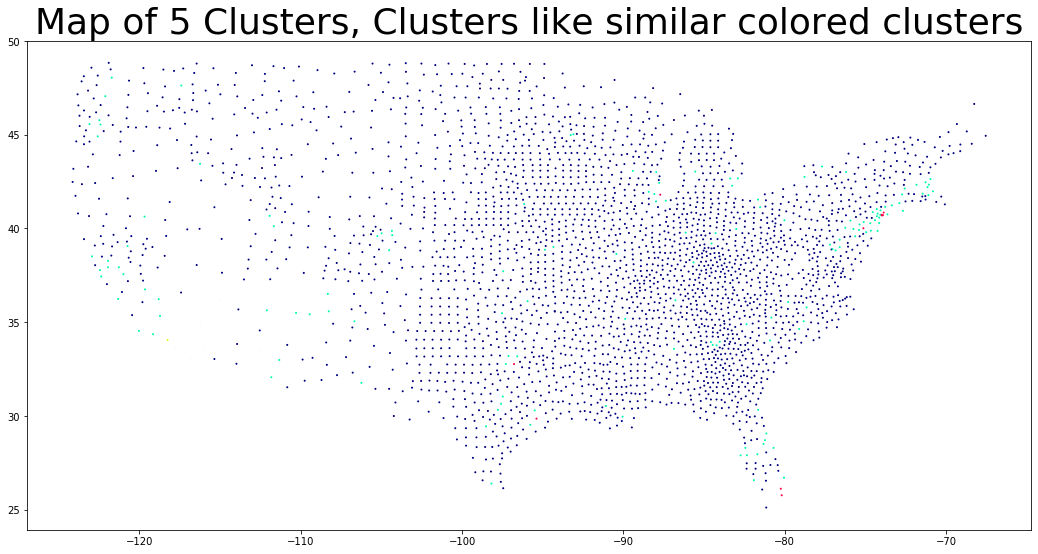

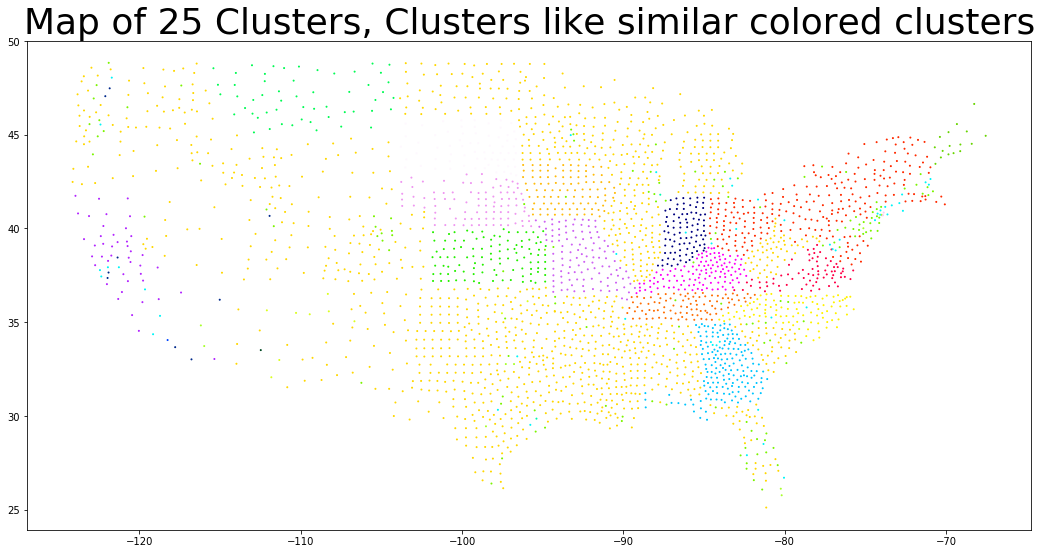

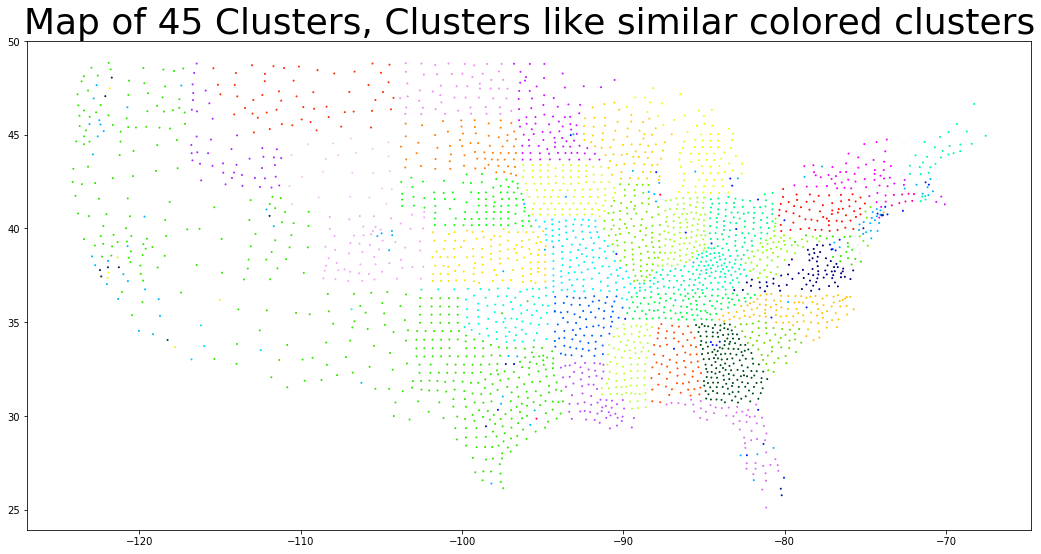

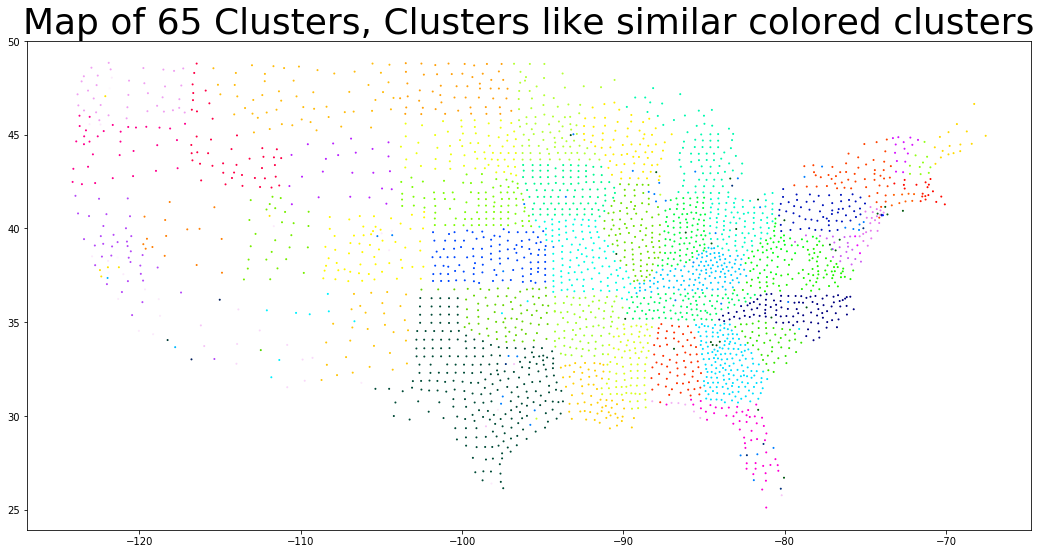

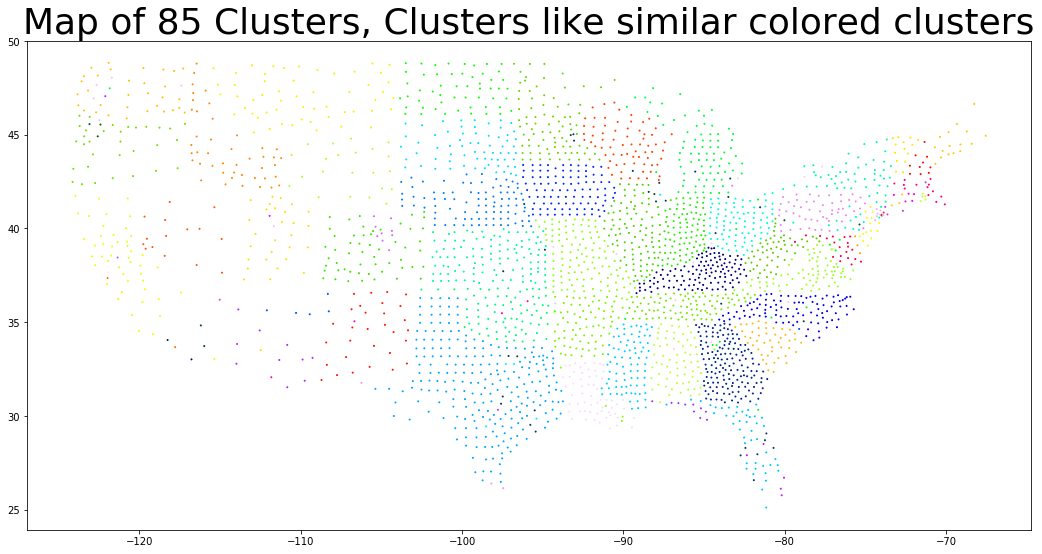

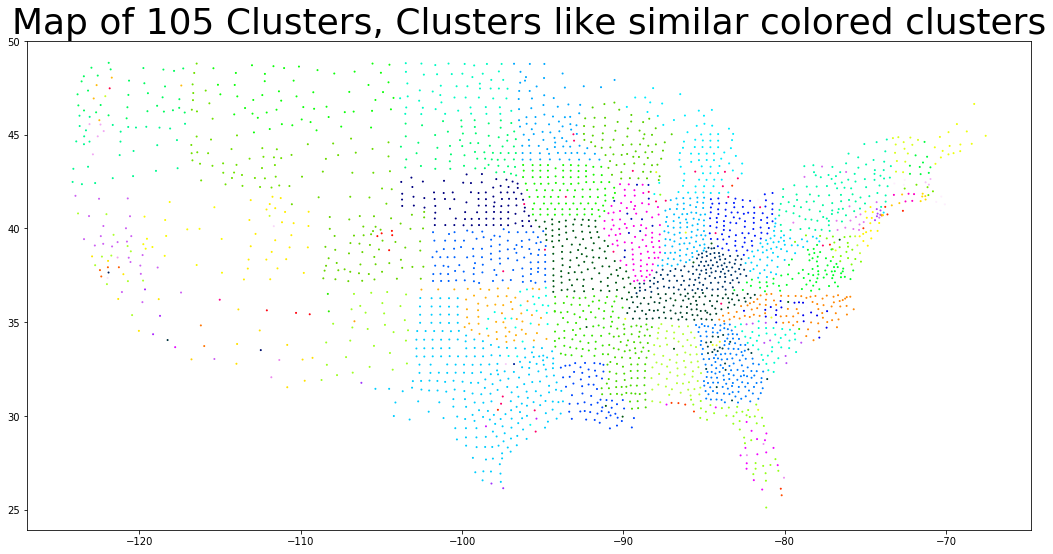

In [46]:

for i in range(5, 125, 20):
    cluster_map(big_data, all_feats, i, cmap=colors);

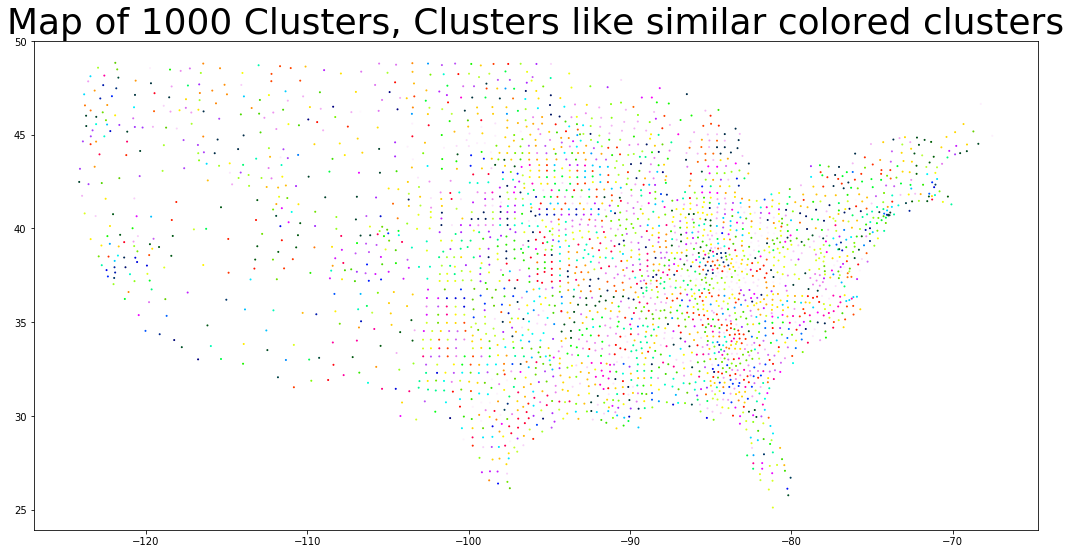

In [47]:
cluster_map(big_data, all_feats, 1000, cmap=colors);

In [48]:
all_feats

['confirmed_cases',
 'deaths',
 'longitude',
 'average_temperature_celsius',
 'rainfall_mm',
 'AK',
 'AL',
 'AR',
 'AS',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'GU',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MP',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'PR',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VI',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY',
 'Employer_contrib_govt_and_social_insurance',
 'Income_maintenance_benefits',
 'Percapita_unemployment_insurance_compensation',
 'Wages_and_salaries_supplement',
 'Wages_and_salaries_avg',
 'Net_earnings_by_place_of_residence',
 'Percapita_personal_income',
 'Population',
 'jobs',
 'AGEGRP',
 'TOT_POP',
 'TOT_MALE',
 'TOT_FEMALE',
 'WA_MALE',
 'WA_FEMALE',
 'BA_MALE',
 'BA_FEMALE',
 'IA_MALE',
 'IA_FEMALE',
 'AA_MALE',
 'AA_FEMALE',
 'NA_MALE',
 'NA_FEMALE',
 'TOM_MALE',
 'TOM_FEMALE',
 'WAC_MALE',
 'WAC_FEMA

In [49]:
demo = [
    'Employer_contrib_govt_and_social_insurance',
 'Income_maintenance_benefits',
 'Percapita_unemployment_insurance_compensation',
 'Wages_and_salaries_supplement',
 'Wages_and_salaries_avg',
 'Net_earnings_by_place_of_residence',
 'Percapita_personal_income',
 'Population',
 'jobs',
 'AGEGRP',
 'TOT_POP',
 'TOT_MALE',
 'TOT_FEMALE',
 'WA_MALE',
 'WA_FEMALE',
 'BA_MALE',
 'BA_FEMALE',
 'IA_MALE',
 'IA_FEMALE',
 'AA_MALE',
 'AA_FEMALE',
 'NA_MALE',
 'NA_FEMALE',
 'TOM_MALE',
 'TOM_FEMALE',
 'WAC_MALE',
 'WAC_FEMALE',
 'BAC_MALE',
 'BAC_FEMALE',
 'IAC_MALE',
 'IAC_FEMALE',
 'AAC_MALE',
 'AAC_FEMALE',
 'NAC_MALE',
 'NAC_FEMALE',
 'NH_MALE',
 'NH_FEMALE',
 'NHWA_MALE',
 'NHWA_FEMALE',
 'NHBA_MALE',
 'NHBA_FEMALE',
 'NHIA_MALE',
 'NHIA_FEMALE',
 'NHAA_MALE',
 'NHAA_FEMALE',
 'NHNA_MALE',
 'NHNA_FEMALE',
 'NHTOM_MALE',
 'NHTOM_FEMALE',
 'NHWAC_MALE',
 'NHWAC_FEMALE',
 'NHBAC_MALE',
 'NHBAC_FEMALE',
 'NHIAC_MALE',
 'NHIAC_FEMALE',
 'NHAAC_MALE',
 'NHAAC_FEMALE',
 'NHNAC_MALE',
 'NHNAC_FEMALE',
 'H_MALE',
 'H_FEMALE',
 'HWA_MALE',
 'HWA_FEMALE',
 'HBA_MALE',
 'HBA_FEMALE',
 'HIA_MALE',
 'HIA_FEMALE',
 'HAA_MALE',
 'HAA_FEMALE',
 'HNA_MALE',
 'HNA_FEMALE',
 'HTOM_MALE',
 'HTOM_FEMALE',
 'HWAC_MALE',
 'HWAC_FEMALE',
 'HBAC_MALE',
 'HBAC_FEMALE',
 'HIAC_MALE',
 'HIAC_FEMALE',
 'HAAC_MALE',
 'HAAC_FEMALE',
 'HNAC_MALE',
 'HNAC_FEMALE'
]

In [50]:
covid_feats = ['confirmed_cases', 'deaths']
weather_feats = ['average_temperature_celsius', 'rainfall_mm']

feature_iterations = [all_feats, demo, covid_feats, weather_feats]

Demographis Only


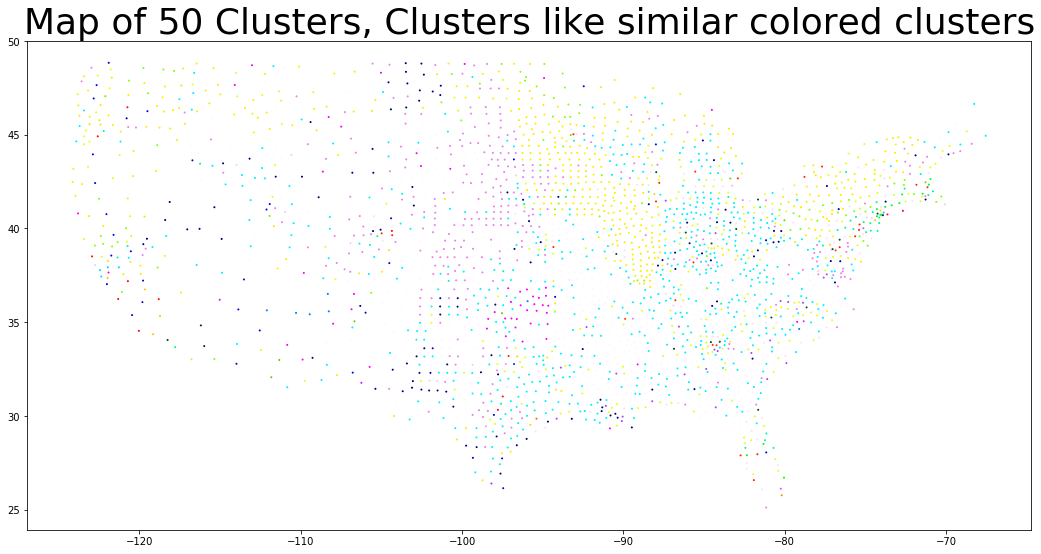

In [51]:
print('Demographis Only')
cluster_map(big_data, demo, 50, cmap=colors);

Covid Numbers Only


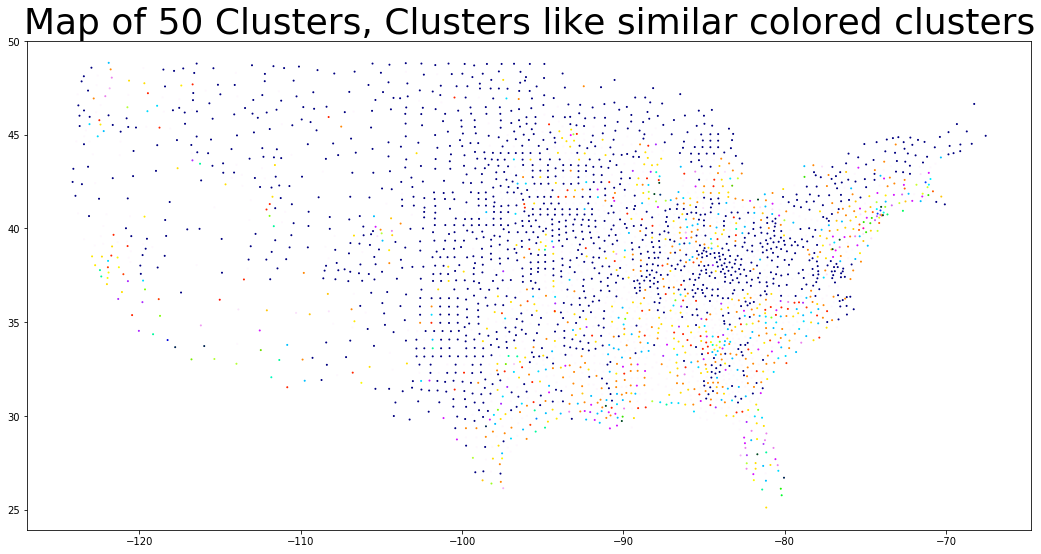

In [52]:
print('Covid Numbers Only')
cluster_map(big_data, covid_feats, 50, colors);

## Feature Engineering
We want to look at a few numbers more quickly, such as deaths per capita in a county

In [53]:
big_data['deaths_per_100K'] = big_data['deaths'] / (big_data['Population'] / 100_000)

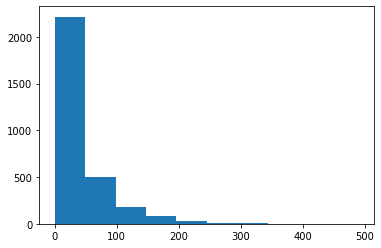

In [54]:
plt.hist(big_data['deaths_per_100K']);

We see that the majority of counties have less than 100 deaths per 100K

In [55]:
big_data.to_csv(datapath + 'covid_socioeconomics_temps.csv')

## Send to Tableau

The above cluster maps help us to see patterns in the data such as geographic areas that have a lot of similarities and how the clusters of covid cases and deaths relate to the clusters of socio-economic data. However, we are using the latitude and logitude points for each county as the point of reference, and this can make it slightly harder to see.

As such, let's port this over to Tableau or Google Data Studio to see how they look in a different setting. We should also look in to GeoPandas to see if that library will help us render better maps.

In [56]:
big_data.columns

Index(['date', 'state', 'confirmed_cases', 'deaths', 'latitude', 'longitude',
       'average_temperature_celsius', 'rainfall_mm', 'fips', 'AK',
       ...
       'HWAC_FEMALE', 'HBAC_MALE', 'HBAC_FEMALE', 'HIAC_MALE', 'HIAC_FEMALE',
       'HAAC_MALE', 'HAAC_FEMALE', 'HNAC_MALE', 'HNAC_FEMALE',
       'deaths_per_100K'],
      dtype='object', length=150)

In [57]:
cb_cov_project = big_data.copy()

In [58]:
cb_cov_project.to_csv(datapath + 'cb_cov_project.csv')

In [67]:
big_data['deaths_per_100K'].sort_values(ascending=False).head(10)

county_state
Hancock County, Georgia             491.135601
Randolph County, Georgia            409.776087
Terrell County, Georgia             360.004645
Neshoba County, Mississippi         353.648069
McKinley County, New Mexico         348.595933
East Feliciana Parish, Louisiana    336.700337
Jenkins County, Georgia             333.985950
Holmes County, Mississippi          329.134037
Early County, Georgia               312.286523
Perkins County, Nebraska            307.272107
Name: deaths_per_100K, dtype: float64

## Above, the 10 deadliest counties per capita

## Below, the 25 deadliest counties per capita

In [68]:
big_data['deaths_per_100K'].sort_values(ascending=False).head(25)

county_state
Hancock County, Georgia             491.135601
Randolph County, Georgia            409.776087
Terrell County, Georgia             360.004645
Neshoba County, Mississippi         353.648069
McKinley County, New Mexico         348.595933
East Feliciana Parish, Louisiana    336.700337
Jenkins County, Georgia             333.985950
Holmes County, Mississippi          329.134037
Early County, Georgia               312.286523
Perkins County, Nebraska            307.272107
Brooks County, Texas                295.192578
Bronx County, New York              279.094385
Turner County, Georgia              278.058645
Leflore County, Mississippi         273.176804
Lowndes County, Alabama             270.703830
Essex County, New Jersey            265.577349
Queens County, New York             263.108702
Northampton County, Virginia        255.645505
Sharkey County, Mississippi         251.313685
Passaic County, New Jersey          248.554569
Union County, New Jersey            242.981577


All of the 10 deadliest counties and most of the 25 deadliest are rural counties. This runs contrary to the normal thought process that densely populated cities would be the deadliest areas.

In the next cell, let's look at Red River Parish, Louisiana, the 25th most deadly county in the nation. It has only about 8500 residents, about 5000 of which are White, 3500 or so are non-white. In the non-white segment, about 2400 residenta are African American and the remaining hundred or so are Native American, Native Hawaiian, or Asian. So roughly 41% of the county is non-white.

Percapita personal income in the county averages 42K per year.

In [72]:
big_data.loc['Red River Parish, Louisiana'][demo].head(-25)

Employer_contrib_govt_and_social_insurance         8470
Income_maintenance_benefits                       11549
Percapita_unemployment_insurance_compensation        38
Wages_and_salaries_supplement                     36495
Wages_and_salaries_avg                            41918
Net_earnings_by_place_of_residence               190957
Percapita_personal_income                         42201
Population                                         8477
jobs                                               3155
AGEGRP                                                0
TOT_POP                                            8442
TOT_MALE                                           4044
TOT_FEMALE                                         4398
WA_MALE                                            2388
WA_FEMALE                                          2545
BA_MALE                                            1573
BA_FEMALE                                          1777
IA_MALE                                         

On the other hand, Brooks County, Texas is the number 11 deadliest county in the country, with 295 deaths per 100K in the county, and has a 97% white population. Also quite rural, Brooks County has only 7100 residents.

The Percapita personal income is just shy of 34K.

In [73]:
big_data.loc['Brooks County, Texas'][demo].head(-25)

Employer_contrib_govt_and_social_insurance         8663
Income_maintenance_benefits                       13214
Percapita_unemployment_insurance_compensation        83
Wages_and_salaries_supplement                     35898
Wages_and_salaries_avg                            42522
Net_earnings_by_place_of_residence               100623
Percapita_personal_income                         33861
Population                                         7114
jobs                                               2763
AGEGRP                                                0
TOT_POP                                            7093
TOT_MALE                                           3616
TOT_FEMALE                                         3477
WA_MALE                                            3484
WA_FEMALE                                          3359
BA_MALE                                              42
BA_FEMALE                                            36
IA_MALE                                         

Look at the least-deadly counties in the country:

In [77]:
big_data['deaths_per_100K'].sort_values().head(25)

county_state
Jones County, South Dakota         0.0
De Baca County, New Mexico         0.0
Powell County, Kentucky            0.0
Robertson County, Kentucky         0.0
Wright County, Missouri            0.0
Ritchie County, West Virginia      0.0
Noble County, Ohio                 0.0
Paulding County, Ohio              0.0
Delta County, Texas                0.0
Pike County, Ohio                  0.0
Spencer County, Kentucky           0.0
Trigg County, Kentucky             0.0
Trimble County, Kentucky           0.0
Wayne County, Kentucky             0.0
Wolfe County, Kentucky             0.0
Calhoun County, West Virginia      0.0
Barton County, Missouri            0.0
Atchison County, Missouri          0.0
Collingsworth County, Texas        0.0
Alfalfa County, Oklahoma           0.0
Childress County, Texas            0.0
Beaver County, Oklahoma            0.0
Carson County, Texas               0.0
Baylor County, Texas               0.0
Doddridge County, West Virginia    0.0
Name: deaths

## Are we reading the economic numbers wrong?

As seen in the cell below, Pike County, Ohio, the tenth least-deadly county (an average of 0.0 deaths per 100K) has a population of about 28000 with about 26500 white people, just over 500 black people and just over 500 Native American people. 

The Percapita personal income is about 37K. This is in line with the averages of the deadliest per-capita counties. It is worth noting that a county with only 10K residents moves to 400 deaths per 100K when 4 people die. So is a county with 0 deaths actually any safer than a county with 4 deaths? 

It may be more valueable to look at the weekly change in deaths, or even weekly change in confirmed cases, to see what areas are experiencing hot spots.


In [78]:
big_data.loc['Pike County, Ohio'][demo].head(-25)

Employer_contrib_govt_and_social_insurance        39141
Income_maintenance_benefits                       35176
Percapita_unemployment_insurance_compensation        82
Wages_and_salaries_supplement                    121284
Wages_and_salaries_avg                            51413
Net_earnings_by_place_of_residence               574900
Percapita_personal_income                         37443
Population                                        28067
jobs                                              10311
AGEGRP                                                0
TOT_POP                                           27772
TOT_MALE                                          13724
TOT_FEMALE                                        14048
WA_MALE                                           13128
WA_FEMALE                                         13484
BA_MALE                                             198
BA_FEMALE                                           129
IA_MALE                                         

In [87]:
covid_feats.append('deaths_per_100K')

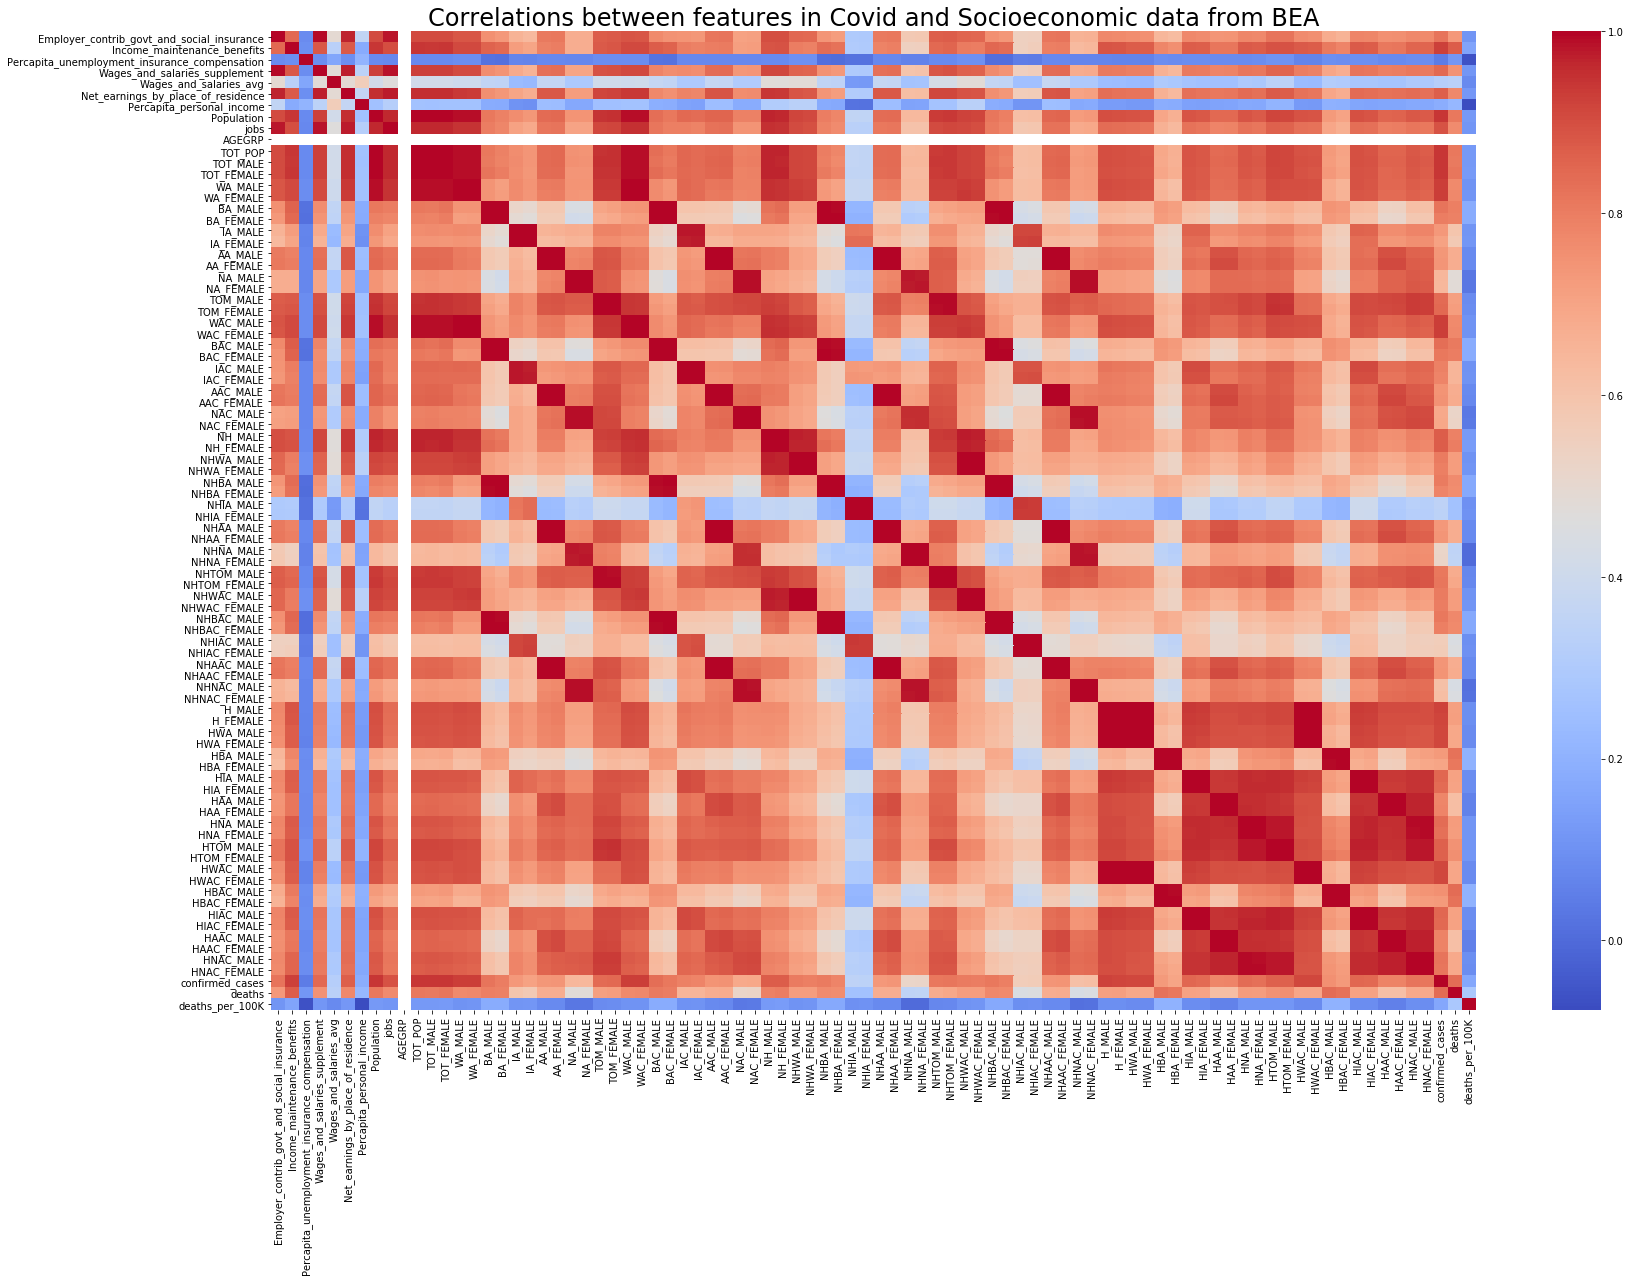

In [90]:
decomo = demo + covid_feats

plt.figure(figsize=(27, 18))
sns.heatmap(big_data[decomo].corr(), cmap='coolwarm',);
plt.title("Correlations between features in Covid and Socioeconomic data from BEA", fontsize=24);

## More Feature Engineering
Create broader columns for the major ethnicities and genders

In [92]:
ethnos = ['WAC_MALE','WAC_FEMALE','BAC_MALE','BAC_FEMALE',
          'IAC_MALE','IAC_FEMALE','AAC_MALE','AAC_FEMALE',
          'NAC_MALE','NAC_FEMALE', 'H_MALE','H_FEMALE'  
          ]

In [93]:
big_data['pct_white'] = (big_data['WAC_MALE'] + big_data['WAC_FEMALE']) / big_data['Population']
big_data['pct_black'] = (big_data['BAC_MALE'] + big_data['BAC_FEMALE']) / big_data['Population']
big_data['pct_asian'] = (big_data['AAC_MALE'] + big_data['AAC_FEMALE']) / big_data['Population']
big_data['pct_hispanic'] = (big_data['H_MALE'] + big_data['H_FEMALE']) / big_data['Population']
big_data['pct_native_american'] = (big_data['IAC_MALE'] + big_data['IAC_FEMALE']) / big_data['Population']
big_data['pct_hawaiian'] = (big_data['NAC_MALE'] + big_data['NAC_FEMALE']) / big_data['Population']

In [105]:
pct_ethnos = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic', 'pct_native_american', 'pct_hawaiian']

In [106]:
financial = ['Employer_contrib_govt_and_social_insurance',
 'Income_maintenance_benefits',
 'Percapita_unemployment_insurance_compensation',
 'Wages_and_salaries_supplement',
 'Wages_and_salaries_avg',
 'Net_earnings_by_place_of_residence',
 'Percapita_personal_income',
 'Population',
 'jobs'
]

In [107]:
decomo = covid_feats + pct_ethnos + financial

In [108]:
print(list(big_data.columns))

['date', 'state', 'confirmed_cases', 'deaths', 'latitude', 'longitude', 'average_temperature_celsius', 'rainfall_mm', 'fips', 'AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY', 'GeoFIPS', 'Employer_contrib_govt_and_social_insurance', 'Income_maintenance_benefits', 'Percapita_unemployment_insurance_compensation', 'Wages_and_salaries_supplement', 'Wages_and_salaries_avg', 'Net_earnings_by_place_of_residence', 'Percapita_personal_income', 'Population', 'jobs', 'AGEGRP', 'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MAL

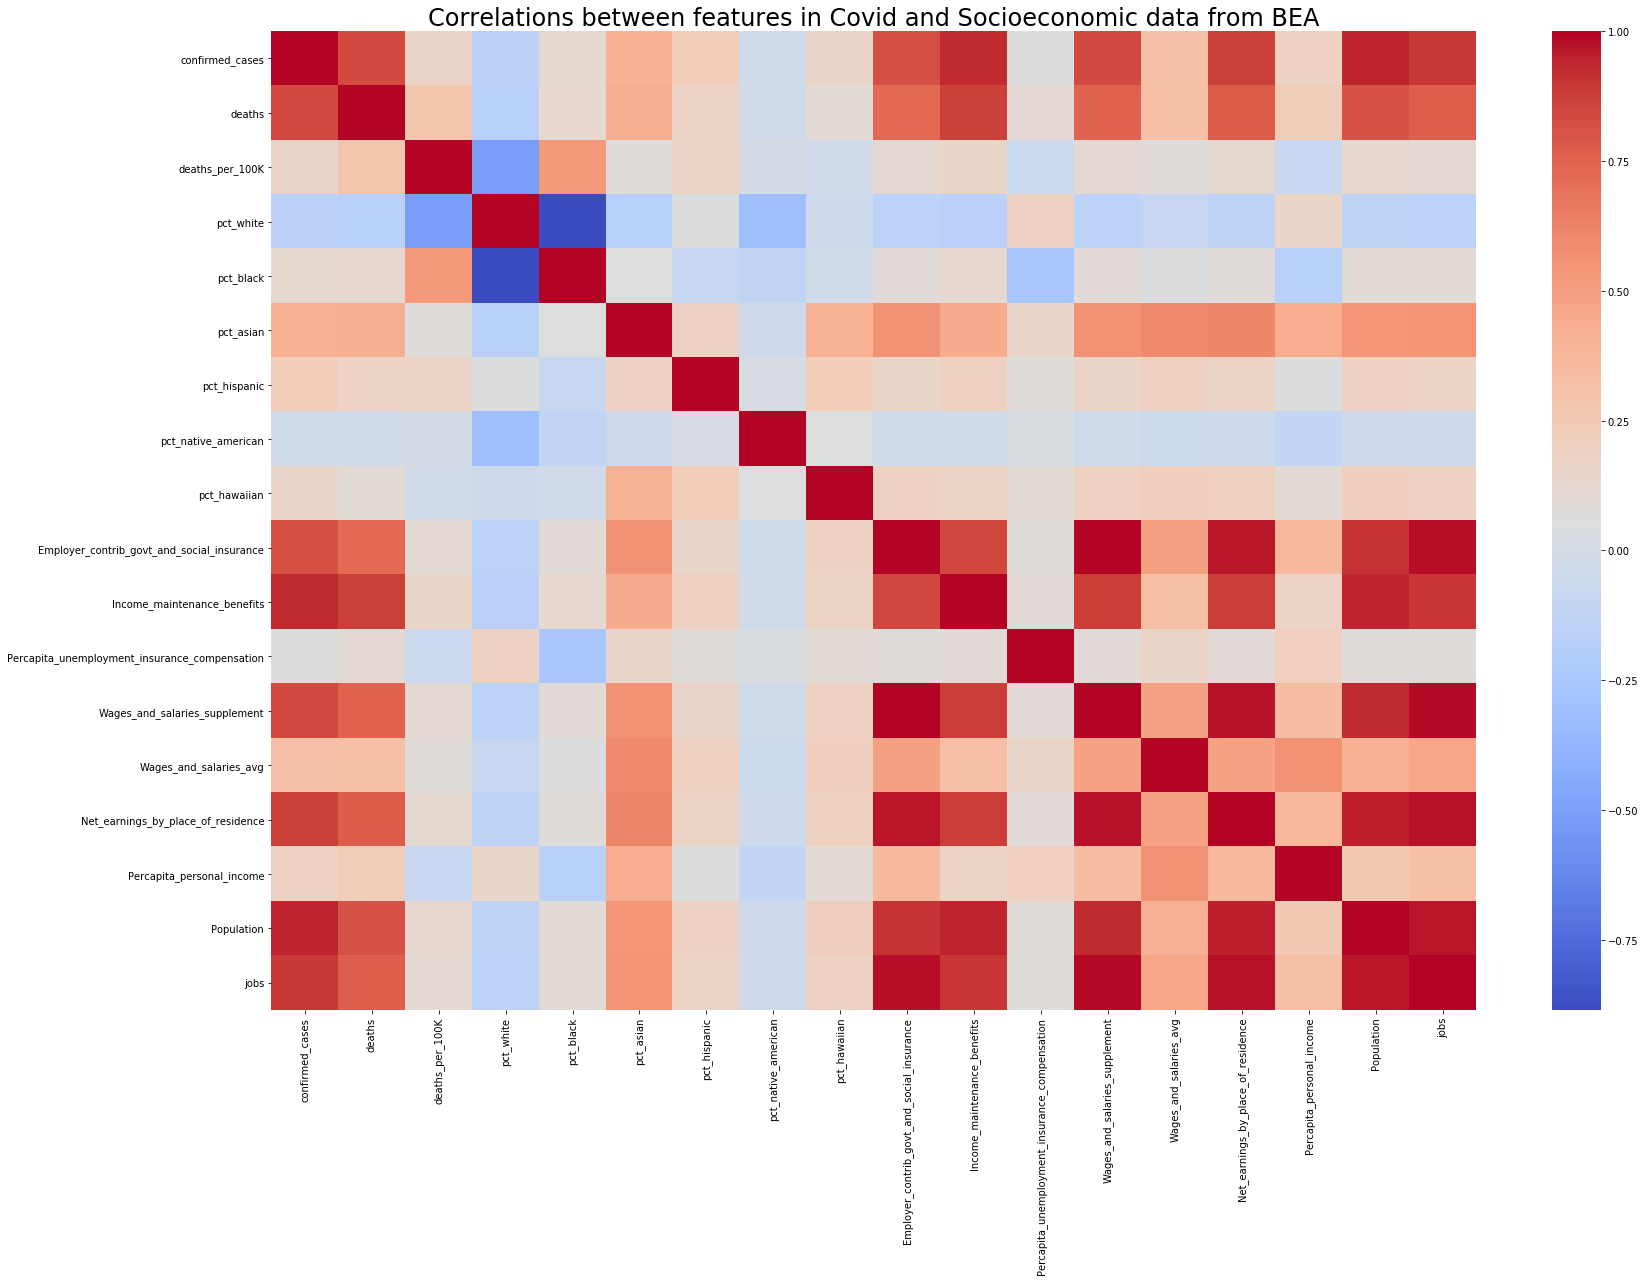

In [109]:
plt.figure(figsize=(27, 18))
sns.heatmap(big_data[decomo].corr(), cmap='coolwarm',);
plt.title("Correlations between features in Covid and Socioeconomic data from BEA", fontsize=24);

## Now use PCA
Principle Component Analysis will take our 156 (or so) column dataframe and break it down in to the components that are most informative in our model. 

In [110]:
big_data.shape

(3035, 156)

## Run K-Means clusters and put the results into the data table

In [120]:
model_df = big_data[covid_feats + pct_ethnos + financial]
model_features = covid_feats + pct_ethnos + financial

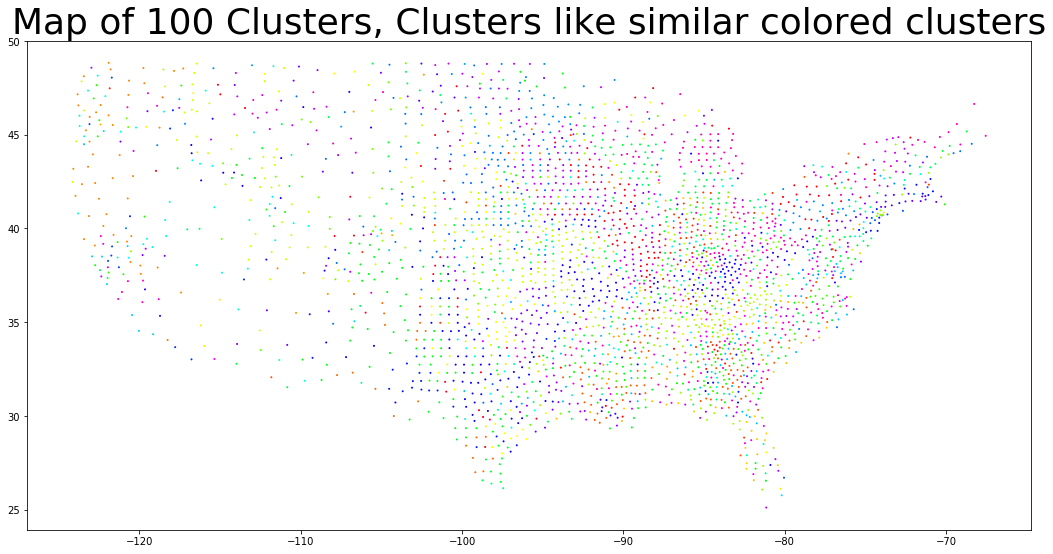

In [124]:
model_1 = cluster_map(big_data, model_features, 100, cmap='gist_rainbow');

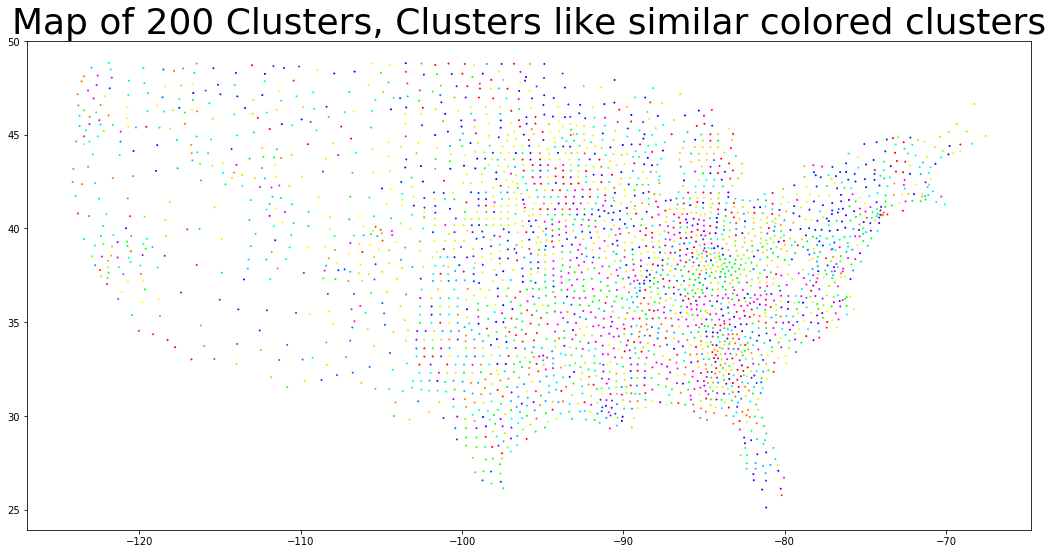

In [125]:
model_2 = cluster_map(big_data, model_features, 200, cmap='gist_rainbow');

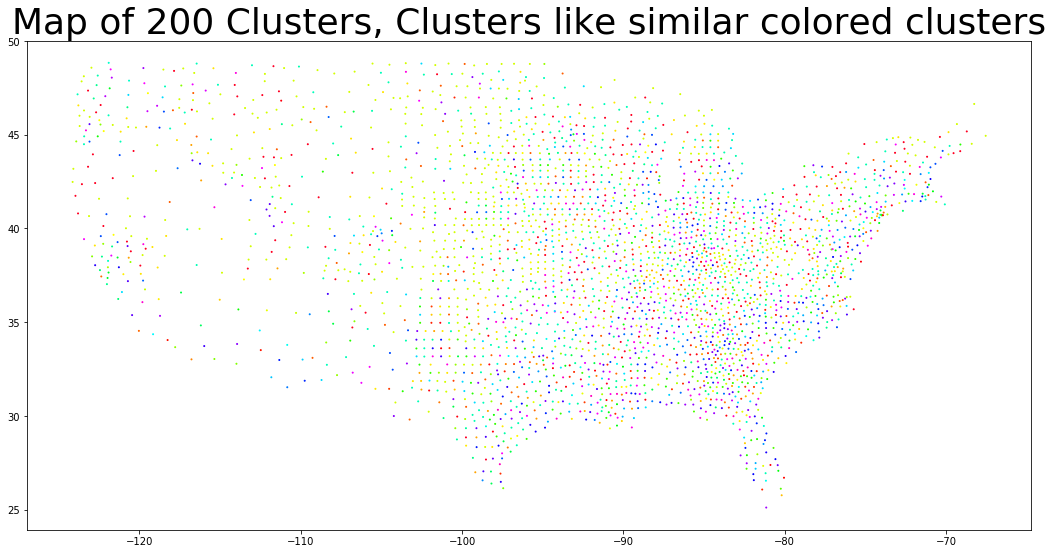

In [126]:
covid_only_2 = cluster_map(big_data, covid_feats, 200, cmap='gist_rainbow');

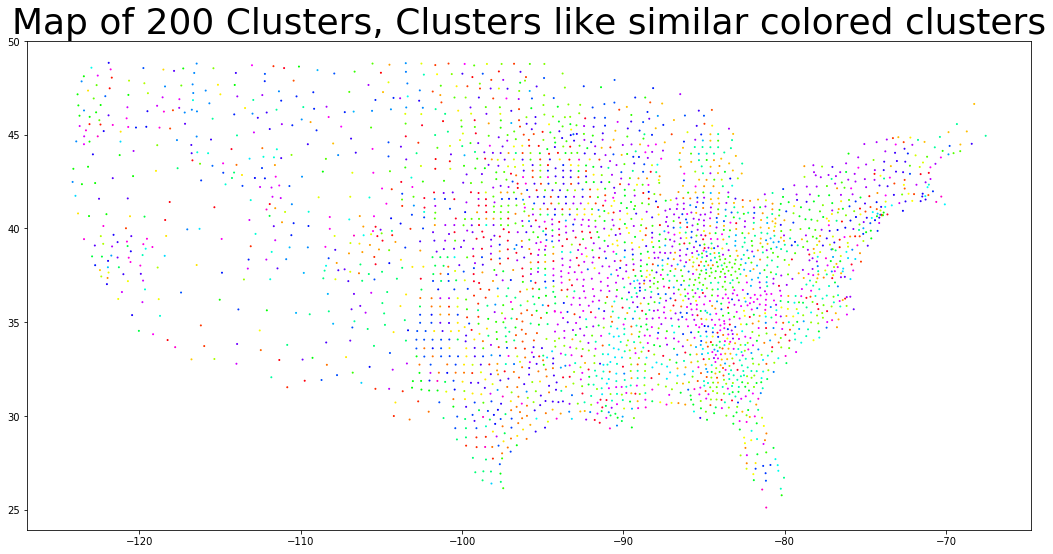

In [129]:
model_features_2A = pct_ethnos + financial
model_2A = cluster_map(big_data, model_features_2A, 200, cmap='gist_rainbow');

In [132]:
# Add the clusters from covid_only_2 and model_2A 
# (does not include the covid data in model_2A) to
# the big_data dataframe

big_data['cluster_cov'] = covid_only_2.labels_
big_data['cluster_demog'] = model_2A.labels_

In [133]:
clus_copy = big_data.copy()
clus_copy.to_csv(datapath + 'two_clusters.csv')

## Now complete the API in Tableau and mirror in Google Data Studio